## Persist Cleaned Data to SQLite

To support database-driven workflows, we load the cleaned hospital CSV into a Pandas DataFrame and then write it into a SQLite database (`hospital_data.db`). We replace any existing table named `hospital_costs_sqlite_cleaned` and verify the list of tables in the database to confirm the operation succeeded.

In [13]:
import sqlite3
import pandas as pd

# Define full path to the CSV file
csv_path = "/Users/anesuruzvidzo/Desktop/Hospital_Reimbursement_Project/Data/cleaned/hospital_costs_sqlite_cleaned.csv"

# Read the cleaned CSV into a DataFrame
df_csv = pd.read_csv(csv_path)

# Connect (or create) hospital_data.db in the project root
conn = sqlite3.connect("/Users/anesuruzvidzo/Desktop/Hospital_Reimbursement_Project/hospital_data.db")

# Write the CSV DataFrame into a table named "hospital_costs_sqlite_cleaned"
df_csv.to_sql(name="hospital_costs_sqlite_cleaned", con=conn, if_exists="replace", index=False)

# Confirm which tables exist in hospital_data.db
tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables_df)

                            name
0  hospital_costs_sqlite_cleaned


## Verify SQLite Table Import

We read back the `hospital_costs_sqlite_cleaned` table from the `hospital_data.db` SQLite database into a Pandas DataFrame. Displaying the first few rows confirms that the cleaned hospital data was successfully persisted and can be queried directly from the database.

In [14]:
# Read the cleaned table into a DataFrame
df = pd.read_sql_query("SELECT * FROM hospital_costs_sqlite_cleaned", conn)

# Display the first few rows
df.head()

,CCN,Hospital_Name,Total_Charges,Total_Payment,Address,City,State,County,Ownership,Report_Fiscal_Year
0,341318,CHOWAN HOSPITAL INC.,36330775,56681179,211 VIRGINIA AVENUE,EDENTON,NC,CHOWAN,2,2018
1,102012,SPECIALTY HOSPITAL OF JACKSONVILLE,21692290,4729380,4901 RICHARD STREET,JACKSONVILLE,FL,DUVAL,4,2018
2,221300,MARTHAS VINEYARD HOSPITAL,24038629,84069106,ONE HOSPITAL ROAD,OAK BLUFFS,MA,DUKES,2,2018
3,201302,LINCOLNHEALTH,37577199,85209941,6 ST. ANDREWS LANE,BOOTHBAY HARBOR,ME,LINCOLN,2,2018
4,511306,ROANE GENERAL HOSPITAL,10970176,35195713,200 HOSPITAL DRIVE,SPENCER,WV,ROANE,2,2018


## Database Query: Compute Hospital-Level Averages via SQL

Instead of in-memory CSV, we leverage our SQLite database to compute the average charges and payments by fiscal year and hospital (CCN). We then calculate the corresponding charge-to-payment ratio directly from the aggregated values, demonstrating how to use SQL-backed data within our analysis pipeline.

In [16]:
# Compute average charges & payments by year and hospital (CCN)
summary = (
    df
    .groupby(['Report_Fiscal_Year', 'CCN'])
    .agg(
        avg_charge=('Total_Charges', 'mean'),
        avg_payment=('Total_Payment', 'mean')
    )
    .reset_index()
)

# Calculate charge-to-payment ratio
summary['charge_to_payment_ratio'] = summary['avg_charge'] / summary['avg_payment']

# See the first few rows
summary.head()

,Report_Fiscal_Year,CCN,avg_charge,avg_payment,charge_to_payment_ratio
0,2018,10001,859339807.0,340882061.0,2.520930
1,2018,10005,114242849.0,147689469.0,0.773534
2,2018,10006,474412115.0,170503663.0,2.782416
3,2018,10007,17535473.0,14984368.0,1.170251
4,2018,10008,13511264.0,9263645.0,1.458526


## Export Summary Results

After computing the average charges, average payments, and resulting charge-to-payment ratios by year and hospital (CCN), we:

1. **Save** the summary DataFrame to a CSV file (`charge_payment_summary.csv`) for easy reuse.  
2. **Write** the same summary into the SQLite database under the table name `charge_payment_summary` for persistent, queryable storage.  
3. **Close** the database connection to finalize the workflow.

In [17]:
# Save to CSV
summary.to_csv(
    "/Users/anesuruzvidzo/Desktop/Hospital_Reimbursement_Project/charge_payment_summary.csv", 
    index=False
)

# Write into SQLite under a new table "charge_payment_summary"
summary.to_sql(
    name="charge_payment_summary", 
    con=conn, 
    if_exists="replace", 
    index=False
)

# Close the connection
conn.close()

In [18]:
print(sorted(summary["Report_Fiscal_Year"].unique()))

[np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]


## Visualize Time Series: Average Charge-to-Payment Ratio (2018–2022)

We plot the annual trend of average hospital charge-to-payment ratios based on our previously computed `summary` table. This line chart highlights changes in markup behavior over the five-year period.

Matplotlib is building the font cache; this may take a moment.


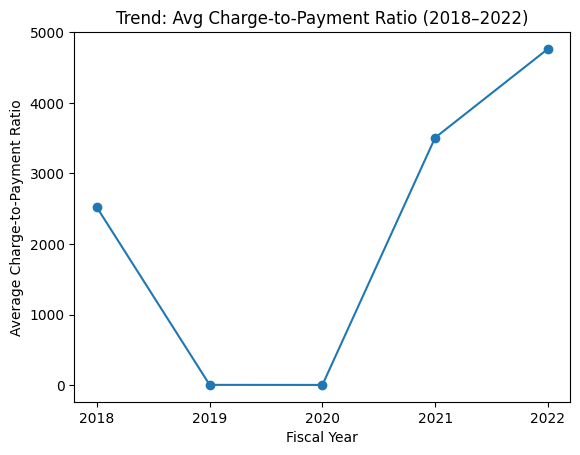

In [21]:
import matplotlib.pyplot as plt

# Compute the average ratio per year
yearly_avg = summary.groupby("Report_Fiscal_Year")["charge_to_payment_ratio"].mean()

# Plot the trend over time
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.xlabel("Fiscal Year")
plt.ylabel("Average Charge-to-Payment Ratio")
plt.title("Trend: Avg Charge-to-Payment Ratio (2018–2022)")
plt.xticks(yearly_avg.index)
plt.show()

## Validate Coverage: Fiscal Years & Hospital Counts

Before drawing conclusions, we verify that our `summary` table includes the intended range of fiscal years (2018–2022) and inspect the number of hospitals represented each year. This ensures our trend analysis is based on complete and consistent data coverage.

In [22]:
# Check which fiscal years are present in the summary DataFrame
# This confirms that data for 2018–2022 (or whatever years) is included
print("Years in summary:", sorted(summary["Report_Fiscal_Year"].unique()))

# Count how many hospitals appear for each year
print("Hospital counts per year:")
print(summary["Report_Fiscal_Year"].value_counts().sort_index())

Years in summary: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Hospital counts per year:
Report_Fiscal_Year
2018    5783
2019    5757
2020    5722
2021    5753
2022    5755
Name: count, dtype: int64


## Top 5 Hospitals by Markup Each Year

We identify the five hospitals with the highest charge-to-payment ratios for each fiscal year. This looped analysis surfaces the facilities with the most extreme markup behavior annually, enabling targeted examination of those cases.

In [23]:
# Identify the top 5 hospitals by charge-to-payment ratio for each year
# Loop over each year in ascending order
for year in sorted(summary["Report_Fiscal_Year"].unique()):
    # Filter summary to only rows for this year
    subset = summary[summary["Report_Fiscal_Year"] == year]
    
    # Select the top 5 hospitals with the highest ratio
    top_5 = (
        subset
        .nlargest(5, "charge_to_payment_ratio")   # order by highest ratio
        .loc[:, ["CCN", "avg_charge", "avg_payment", "charge_to_payment_ratio"]]
    )
    
    # Display the results for this year
    print(f"\nTop 5 Hospitals by Markup in {year}:")
    print(top_5)


Top 5 Hospitals by Markup in 2018:
         CCN    avg_charge  avg_payment  charge_to_payment_ratio
1257  114029  2.909952e+07          2.0             1.454976e+07
5242  474004  2.114416e+07      79683.0             2.653535e+02
1008  100298  1.083045e+08    4380566.0             2.472385e+01
4779  450229  1.357178e+09   63505002.0             2.137120e+01
3298  312024  1.216549e+09   60365155.0             2.015317e+01

Top 5 Hospitals by Markup in 2019:
          CCN  avg_charge  avg_payment  charge_to_payment_ratio
11094  494010  43077770.0      11650.0              3697.662661
10994  474004  18384440.0      19212.0               956.924839
10898  454121  28947600.0     501802.0                57.687295
9452   344033   6531493.5     124282.5                52.553606
6862   104001  37433365.0    1131594.0                33.080208

Top 5 Hospitals by Markup in 2020:
          CCN    avg_charge  avg_payment  charge_to_payment_ratio
14819  312024  4.967184e+09   91584210.0            

## Load Charge‐Payment Summary

Here we import the precomputed hospital‐level summary (`charge_payment_summary.csv`), which includes the average charges, average payments, and calculated charge‐to‐payment ratios by fiscal year and CCN from Notebook 2. This prepares the data for subsequent analyses and visualizations.

In [2]:
import pandas as pd

# Load the summary file created in Notebook 2
summary = pd.read_csv("/Users/anesuruzvidzo/Desktop/Hospital_Reimbursement_Project/charge_payment_summary.csv")

# Confirm it's loaded
summary.head()

,Report_Fiscal_Year,CCN,avg_charge,avg_payment,charge_to_payment_ratio
0,2018,10001,859339807.0,340882061.0,2.520930
1,2018,10005,114242849.0,147689469.0,0.773534
2,2018,10006,474412115.0,170503663.0,2.782416
3,2018,10007,17535473.0,14984368.0,1.170251
4,2018,10008,13511264.0,9263645.0,1.458526


## Comparative Distribution: Filtered Charge-to-Payment Ratios

To compare how markup distributions shift over time, we first remove implausible extreme values (ratios ≥100 or infinite). We then overlay histograms of charge-to-payment ratios for each fiscal year (2018–2022), using semi-transparent bars to visualize changes in the distribution’s shape and spread across years.

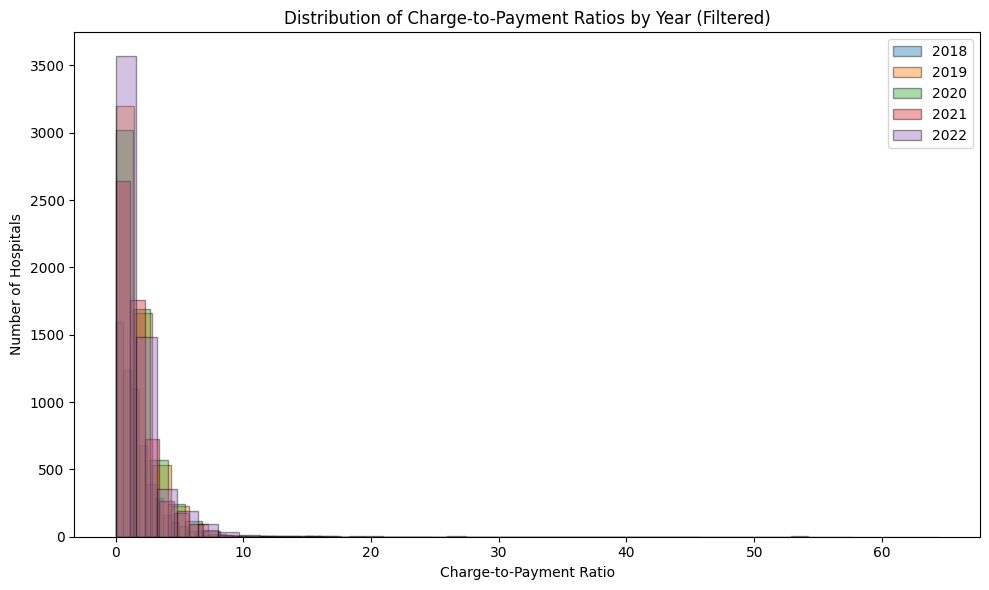

In [3]:
import matplotlib.pyplot as plt

# Filter extreme values to avoid distortion
summary_filtered = summary[
    (summary["charge_to_payment_ratio"] < 100) &
    (summary["charge_to_payment_ratio"].notna()) &
    (summary["charge_to_payment_ratio"] != float("inf"))
]

plt.figure(figsize=(10, 6))

# Plot histogram for each year after filtering
for year in sorted(summary_filtered["Report_Fiscal_Year"].unique()):
    subset = summary_filtered[summary_filtered["Report_Fiscal_Year"] == year]
    
    plt.hist(
        subset["charge_to_payment_ratio"],
        bins=40,
        alpha=0.4,
        label=str(year),
        edgecolor="black"
    )

plt.xlabel("Charge-to-Payment Ratio")
plt.ylabel("Number of Hospitals")
plt.title("Distribution of Charge-to-Payment Ratios by Year (Filtered)")
plt.legend()
plt.tight_layout()
plt.show()

## State-Level Comparison for 2022

In this analysis, we merge the hospital summary ratios with state identifiers, filter for 2022, and compute each state’s average charge-to-payment ratio (excluding extreme values). We then list and visualize the top 10 states by markup ratio to highlight regional variations in hospital pricing practices.

Top 10 States by Avg Charge-to-Payment Ratio (2022):
  State  charge_to_payment_ratio
0    NJ                 3.571127
1    FL                 3.552269
2    NV                 3.058525
3    CA                 2.557203
4    AZ                 2.290159
5    VA                 2.183783
6    TX                 2.141025
7    SC                 2.071146
8    TN                 2.056953
9    DE                 2.023721


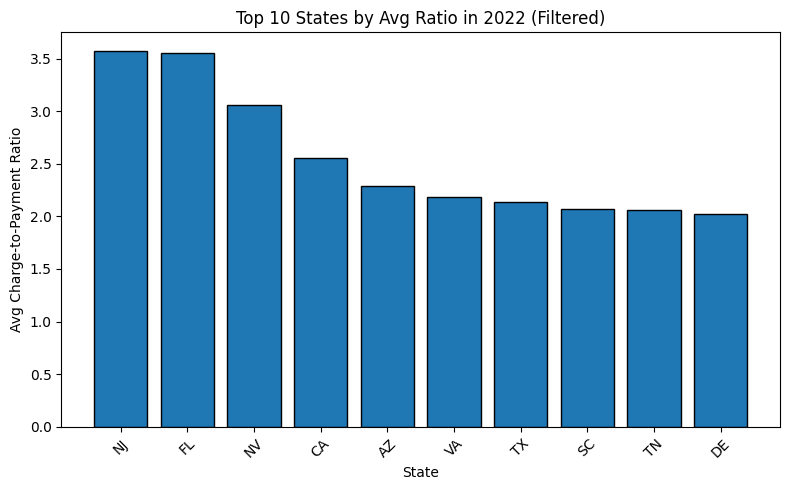

In [5]:
df = pd.read_csv("/Users/anesuruzvidzo/Desktop/Hospital_Reimbursement_Project/Data/cleaned/hospital_costs_sqlite_cleaned.csv")

# Compare average ratios across states for a specific year (e.g., 2022)
# First, filter out extreme ratios to avoid distortion
summary_filtered = summary[
    (summary["charge_to_payment_ratio"] < 100) &
    (summary["charge_to_payment_ratio"].notna()) &
    (summary["charge_to_payment_ratio"] != float("inf"))
]

# Then merge the 'State' column from the original df into summary
# We use drop_duplicates to avoid repeating the same CCN–State pairing
merged = summary_filtered.merge(
    df[["CCN", "Report_Fiscal_Year", "State"]].drop_duplicates(),
    on=["CCN", "Report_Fiscal_Year"],
    how="left"
)

# Filter merged DataFrame for the target year (2022 in this example)
subset_2022 = merged[merged["Report_Fiscal_Year"] == 2022]

# Group by state and compute the mean ratio for each
state_avg = (
    subset_2022
    .groupby("State")["charge_to_payment_ratio"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Display the top 10 states with highest average ratio in 2022
print("Top 10 States by Avg Charge-to-Payment Ratio (2022):")
print(state_avg.head(10))

# Plot a bar chart of those top 10 states
import matplotlib.pyplot as plt

top_states = state_avg.head(10)  # select the top 10 states
plt.figure(figsize=(8, 5))       # set figure size
plt.bar(
    top_states["State"], 
    top_states["charge_to_payment_ratio"], 
    edgecolor="black"
)
plt.xlabel("State")
plt.ylabel("Avg Charge-to-Payment Ratio")
plt.title("Top 10 States by Avg Ratio in 2022 (Filtered)")
plt.xticks(rotation=45)  # rotate state labels for readability
plt.tight_layout()       # adjust layout to prevent cut-off labels
plt.show()

In [7]:
# Reopen the SQLite connection so we can write tables back to it
import sqlite3
conn = sqlite3.connect("/Users/anesuruzvidzo/Desktop/Hospital_Reimbursement_Project/hospital_data.db")

## Persist Summary Table to SQLite

We write the `summary` DataFrame—containing average charges, payments, and charge-to-payment ratios—to the SQLite database under the table name `charge_payment_summary`. This enables efficient querying and reuse of the computed results within a database environment.

In [8]:
# Write the summary DataFrame into SQLite under the table "charge_payment_summary"
summary.to_sql(
    name="charge_payment_summary",
    con=conn,
    if_exists="replace",
    index=False
)

28770

In [9]:
#write State average into SQLite under "state_avg_2022"
state_avg.to_sql(
    name="state_avg_2022",
    con=conn,
    if_exists="replace",
    index=False
)

54

In [10]:
# Close the database connection now that all writes are done
conn.close()

In [11]:
# Confirmation message
print("Notebook 02 is complete: summary and state_avg tables have been saved.")

Notebook 02 is complete: summary and state_avg tables have been saved.
